In [89]:
import wandb
import joblib
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import StandardScaler

In [90]:
# Configure WandB
wandb.login()
wandb.init(
    project="Models Test",
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


### Load test dataset

In [91]:
# Load dataset

play_by_play_path = "../../../data/dataframe_2020_to_2021.csv"
play_by_play = pd.read_csv(play_by_play_path)

# Filter for regular-season games and remove missing values
play_by_play = play_by_play.loc[play_by_play["gameType"] == "playoffs"].dropna()

# Remove non-relevant features
X_all_features = play_by_play.drop(play_by_play.columns[[1, 2, 3, 5, 6, 14, 15, 16, 18, 19, 20, 21]], axis=1)
features_to_encode = ["previousEventType", "shotType"]

# Encode categorical features
def encode_and_bind(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    return pd.concat([df.drop(columns=feature), dummies], axis=1)

# Apply encoding on selected features
for feature in features_to_encode:
    X_all_features = encode_and_bind(X_all_features, feature)

# Standardize features (only for random forest)
scaler = StandardScaler()
X_all_features_std = scaler.fit_transform(X_all_features)

X_shot_distance = play_by_play[["shotDistance"]]
X_shot_angle = play_by_play[["shotAngle"]]
X_shot_distance_angle = play_by_play[["shotDistance", "shotAngle"]]

y = play_by_play["isGoal"].values

### Load the models from WandB

In [ ]:
lr_distance_artifact = wandb.use_artifact('philippe-bergeron-7-universit-de-montr-al-org/wandb-registry-model/Logistic regression:v4', type='model')
lr_distance_artifact_dir = lr_distance_artifact.download()

model_path = f"{lr_distance_artifact_dir}/logistic_regression_distance.pkl"
lr_distance_model = joblib.load(model_path)

In [ ]:
lr_angle_artifact = wandb.use_artifact('philippe-bergeron-7-universit-de-montr-al-org/wandb-registry-model/Logistic regression:v3', type='model')
lr_angle_artifact_dir = lr_angle_artifact.download()

model_path = f"{lr_angle_artifact_dir}/logistic_regression_angle.pkl"
lr_angle_model = joblib.load(model_path)

In [ ]:
lr_distance_angle_artifact = wandb.use_artifact('philippe-bergeron-7-universit-de-montr-al-org/wandb-registry-model/Logistic regression:v5', type='model')
lr_distance_angle_artifact_dir = lr_distance_angle_artifact.download()

model_path = f"{lr_distance_angle_artifact_dir}/logistic_regression_dist_angle.pkl"
lr_distance_angle_model = joblib.load(model_path)

In [95]:
xgboost_artifact = wandb.use_artifact('philippe-bergeron-7-universit-de-montr-al-org/wandb-registry-model/XGBoost:v4', type='model')
xgboost_artifact_dir = xgboost_artifact.download()

model_path = f"{xgboost_artifact_dir}/xgboost_all_features.pkl"
xgboost_model = joblib.load(model_path)

wandb: WARNING Registries can be linked/fetched using a shorthand form without specifying the organization name. Try using shorthand path format: <my_registry_name>/<artifact_name> or just <my_registry_name> if fetching just the project.
wandb:   1 of 1 files downloaded.  


In [96]:
random_forest_artifact = wandb.use_artifact('philippe-bergeron-7-universit-de-montr-al-org/wandb-registry-model/Random Forest:v0', type='model')
random_forest_artifact_dir = random_forest_artifact.download()

model_path = f"{random_forest_artifact_dir}/RandomForest_Model.pkl"
rf_model = joblib.load(model_path)

wandb: WARNING Registries can be linked/fetched using a shorthand form without specifying the organization name. Try using shorthand path format: <my_registry_name>/<artifact_name> or just <my_registry_name> if fetching just the project.
wandb:   1 of 1 files downloaded.  


In [97]:
def generate_figures(model, X, y, model_name):
    # Generate predictions and probabilities
    y_pred_probs = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X)
    y_pred = model.predict(X)

    # Random baseline
    np.random.seed(42)
    prob_random = np.random.uniform(0, 1, len(y))

    # Set up subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"{model_name} (Série éliminatoires)", fontsize=16)

    # **1. ROC Curve and AUC**
    ax = axes[0, 0]
    for name, prob in [
        ("Modèle", y_pred_probs),
        ("Aléatoire", prob_random),
    ]:
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    ax.set_xlabel("Taux de faux positifs (FPR)")
    ax.set_ylabel("Taux de vrais positifs (TPR)")
    ax.set_title("Courbe ROC")
    ax.legend()
    ax.grid()

    # **2. Goal Rate by Probability Percentile**
    ax = axes[0, 1]
    for name, prob in [
        ("Modèle", y_pred_probs),
        ("Aléatoire", prob_random),
    ]:
        sorted_indices = np.argsort(prob)
        prob_sorted = np.array(prob[sorted_indices])
        y_sorted = np.array(y[sorted_indices])

        percentiles = np.percentile(prob_sorted, np.arange(0, 101, 10))
        goal_rates = [
            y_sorted[(prob_sorted >= percentiles[i]) & (prob_sorted < percentiles[i + 1])].mean()
            if np.sum((prob_sorted >= percentiles[i]) & (prob_sorted < percentiles[i + 1])) > 0
            else 0
            for i in range(len(percentiles) - 1)
        ]
        ax.plot(np.arange(0, 100, 10), [rate * 100 for rate in goal_rates], label=name)
    ax.set_xlabel("Centile de la probabilité prédite")
    ax.set_ylabel("Taux de buts (%)")
    ax.set_title("Taux de buts par centile de probabilité")
    ax.set_ylim(0, 100)
    ax.grid()
    ax.legend()
    ax.invert_xaxis()

    # **3. Cumulative Goal Proportion**
    ax = axes[1, 0]
    for name, prob in [
        ("Modèle", y_pred_probs),
        ("Aléatoire", prob_random),
    ]:
        sorted_indices = np.argsort(prob)[::-1]
        y_sorted = np.array(y)[sorted_indices]

        cumulative_goals = np.cumsum(y_sorted)
        total_goals = np.sum(y_sorted)

        cumulative_goal_proportion = cumulative_goals / total_goals

        centiles = np.linspace(100, 0, len(cumulative_goal_proportion))
        ax.plot(centiles, cumulative_goal_proportion * 100, label=name)
    ax.set_xlabel("Centile de la probabilité prédite")
    ax.set_ylabel("Proportion cumulée des buts (%)")
    ax.set_title("Proportion cumulée des buts par centile de probabilité")
    ax.set_ylim(0, 100)
    ax.grid()
    ax.legend()
    ax.invert_xaxis()

    # **4. Calibration Curve**
    ax = axes[1, 1]
    for name, prob in [
        ("Modèle", y_pred_probs),
        ("Aléatoire", prob_random),
    ]:
        fraction_of_positives, mean_predicted_value = calibration_curve(y, prob, n_bins=10, strategy="quantile")
        ax.plot(mean_predicted_value, fraction_of_positives, label=name)
    ax.plot([0, 1], [0, 1], "k--", label="Calibration parfaite")
    ax.set_xlabel("Probabilité prédite")
    ax.set_ylabel("Fréquence observée (empirique)")
    ax.set_title("Diagramme de fiabilité (Calibration)")
    ax.legend()
    ax.grid()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [98]:
# Assuming X_all_features is a pandas DataFrame
if 'previousEventType_goal' not in X_all_features.columns:
    X_all_features['previousEventType_goal'] = 0  # Add the missing feature with default value 0

# Ensure the column order matches the training data
X_all_features = X_all_features[[col for col in xgboost_model.feature_names_in_]]
X_all_features_std = np.hstack((X_all_features_std, np.ones((X_all_features_std.shape[0], 1))))


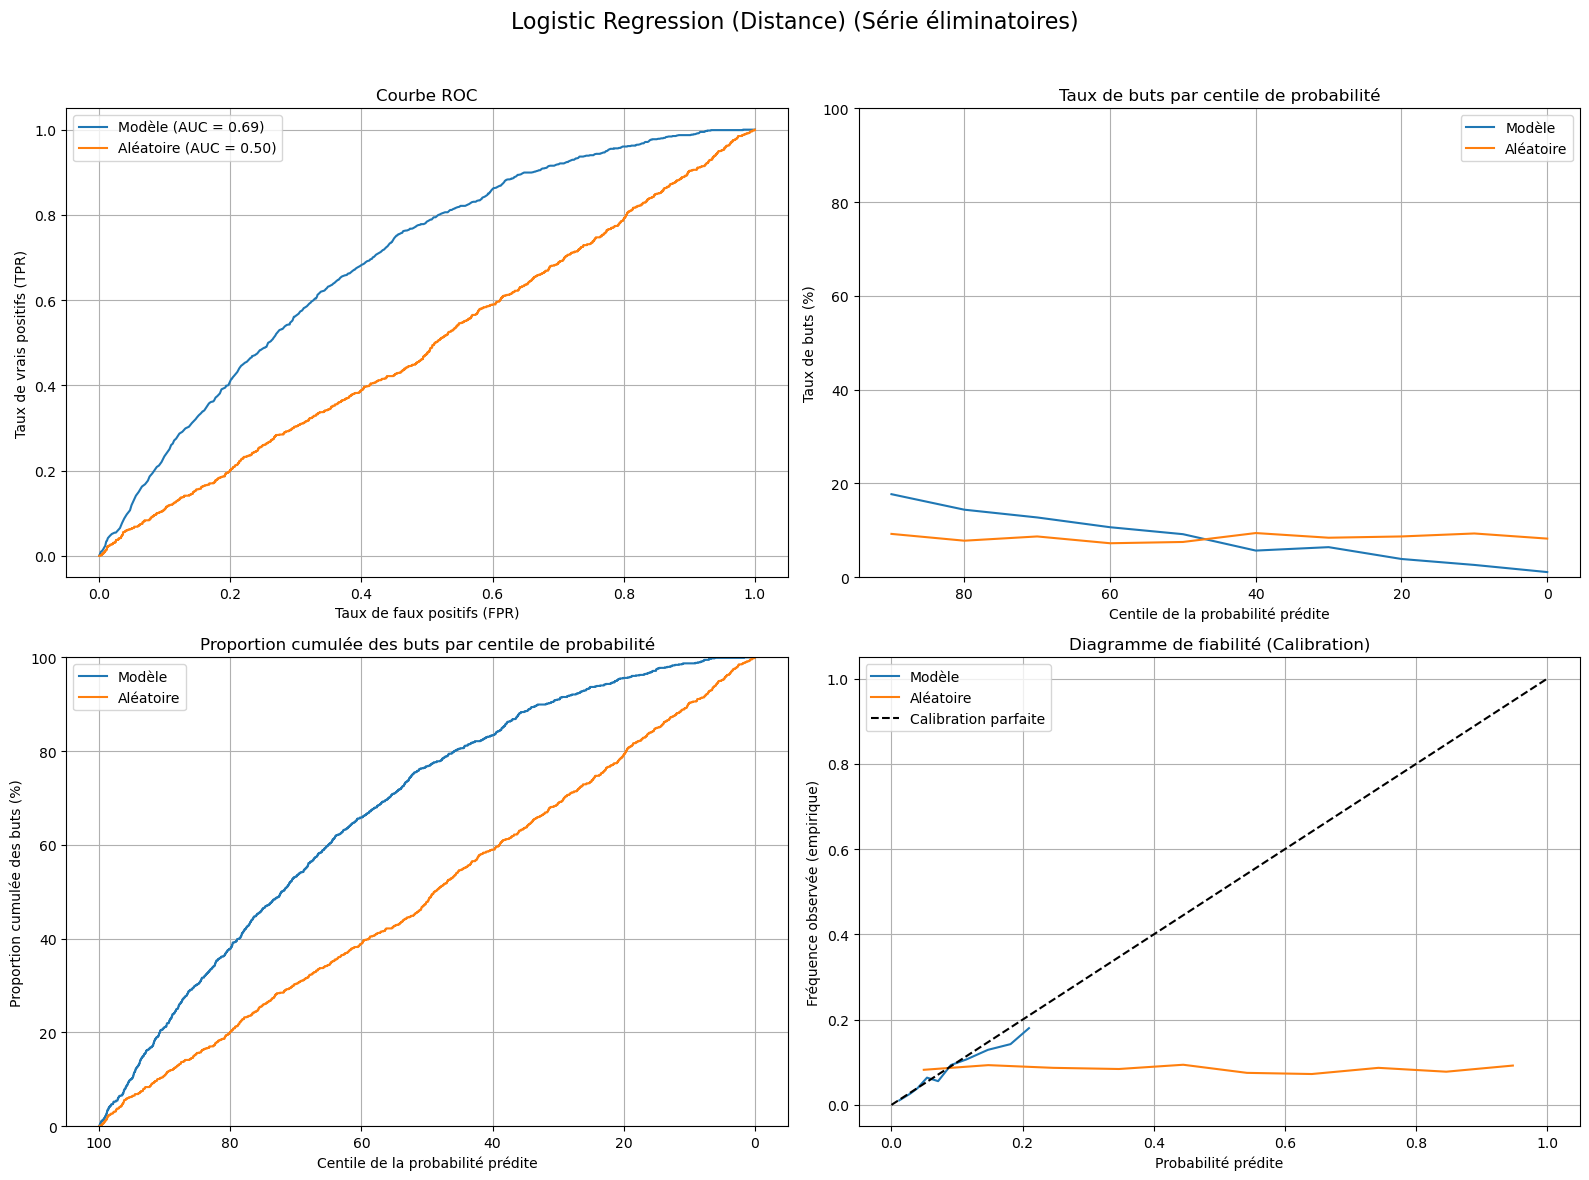

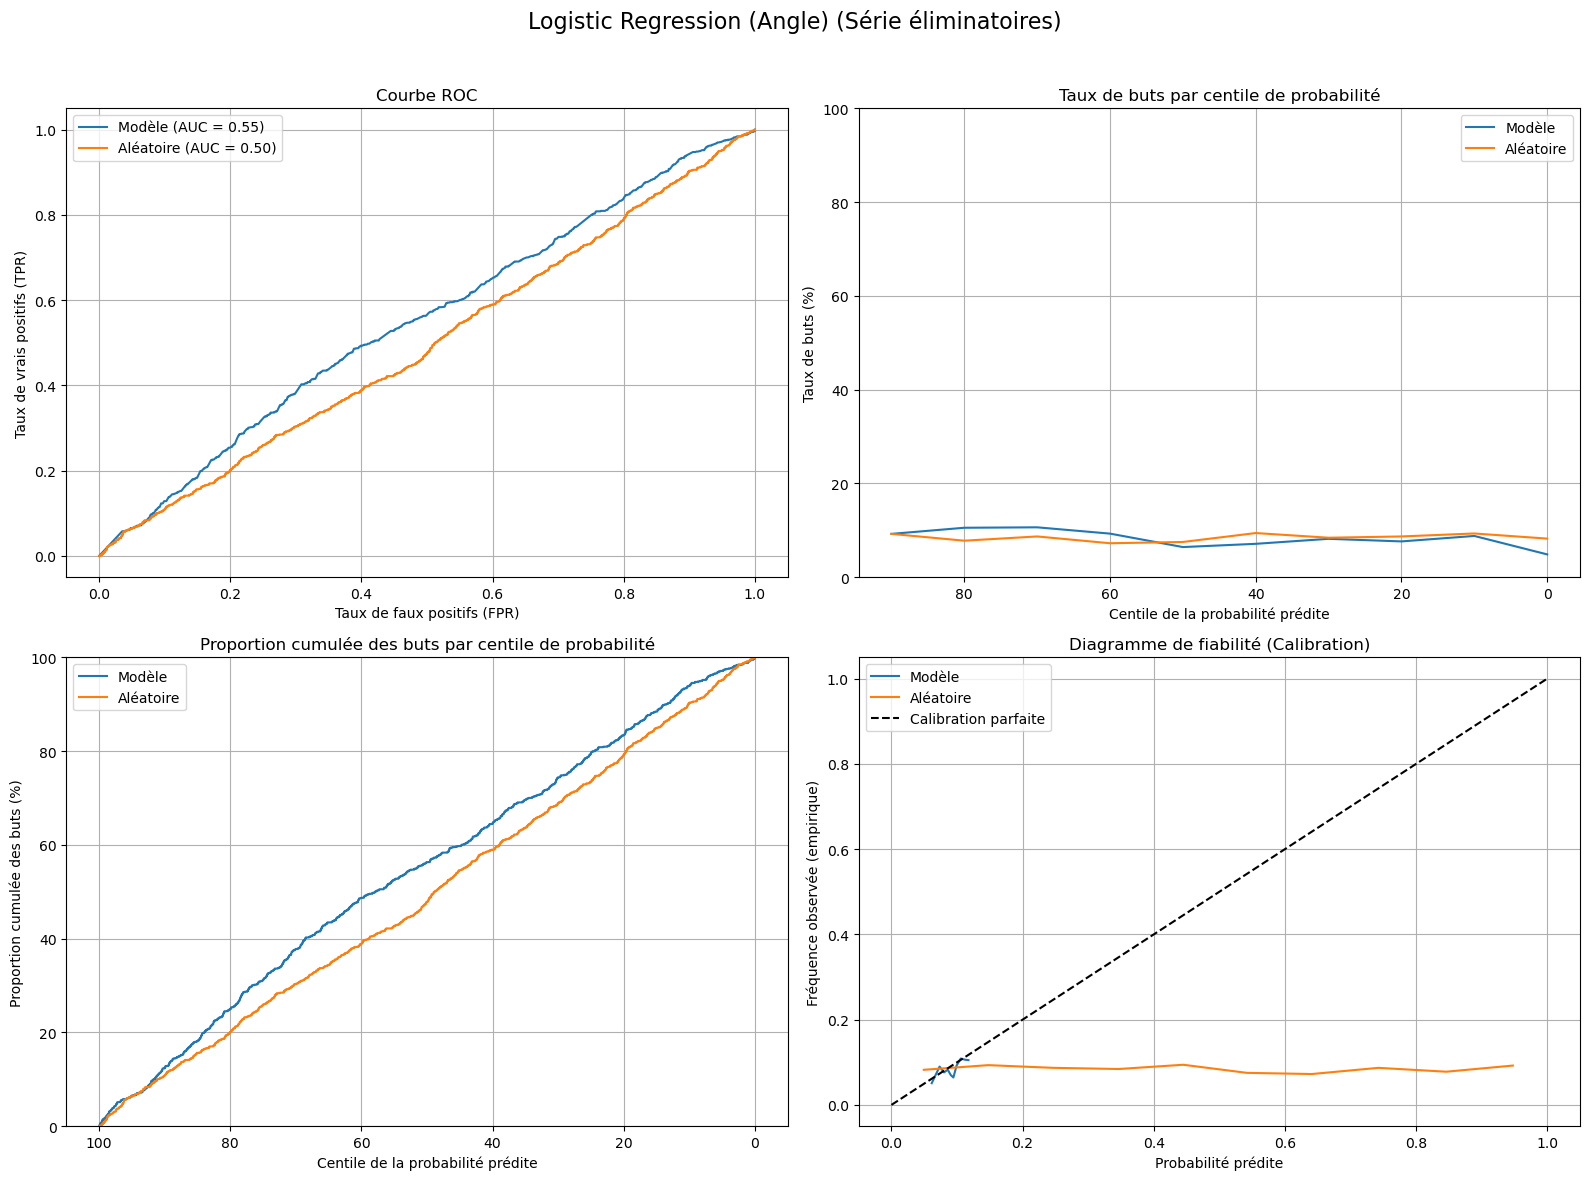

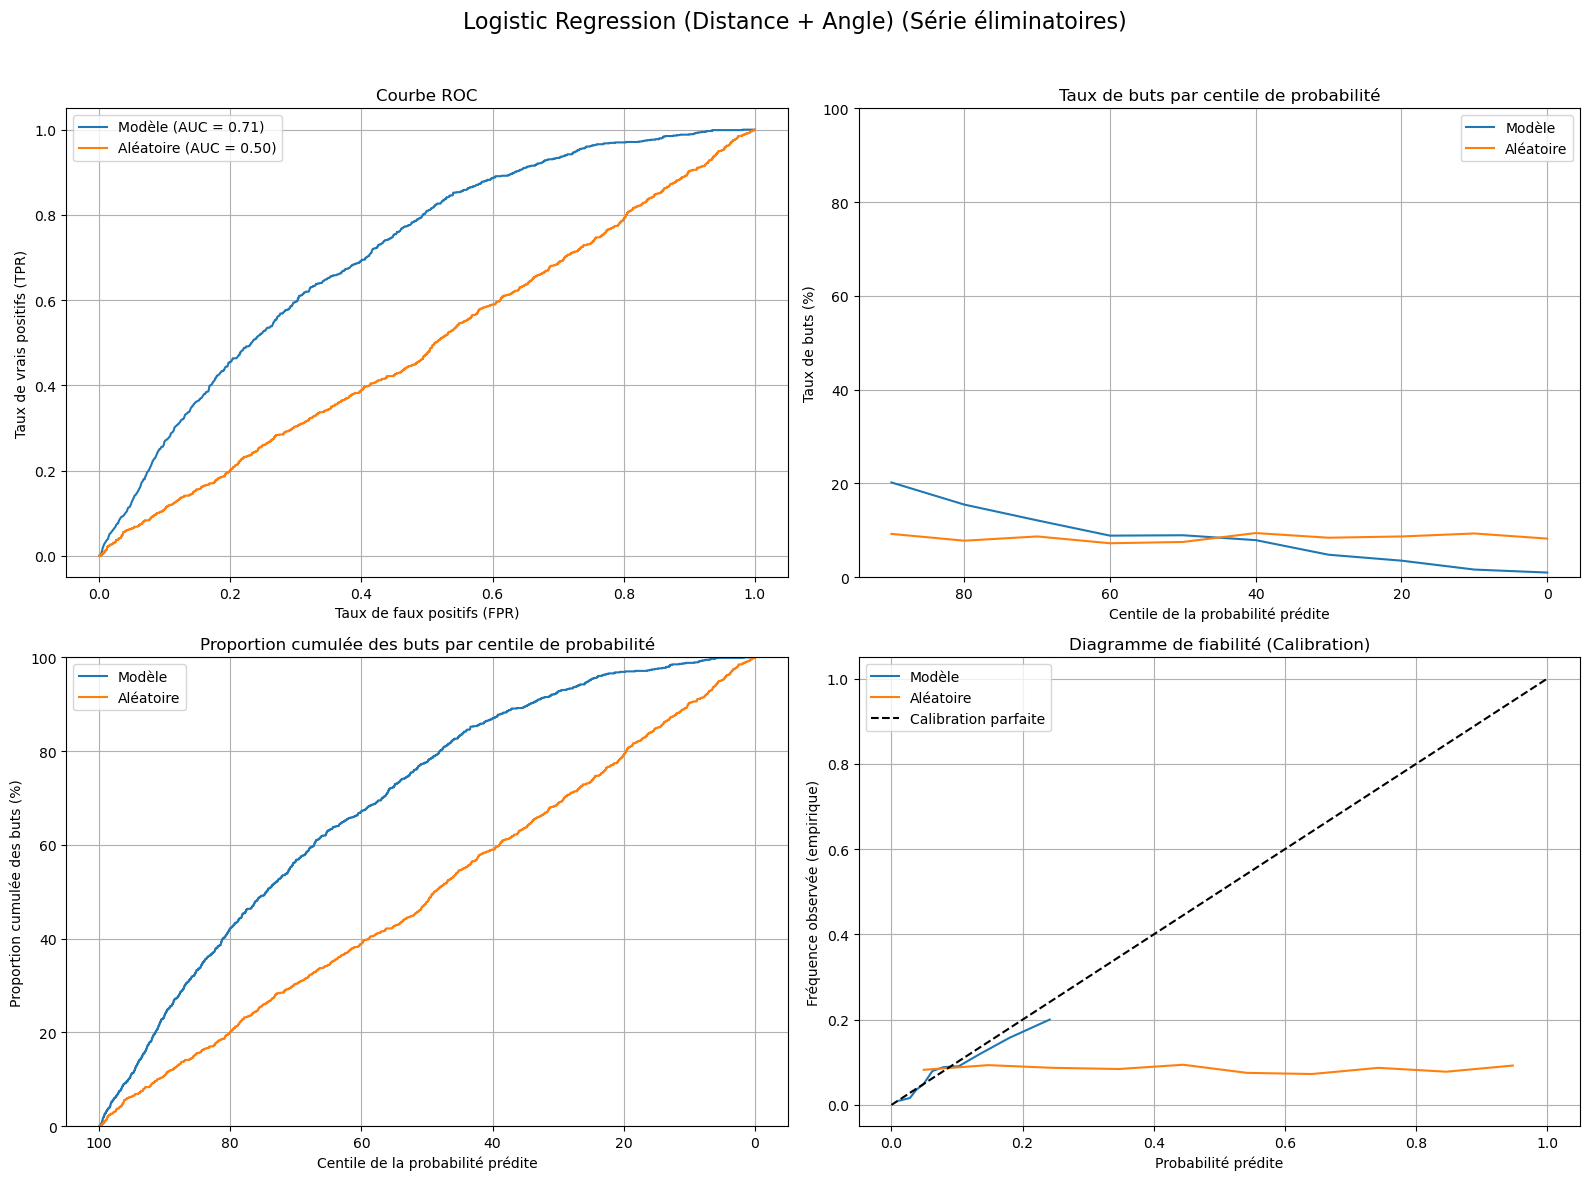

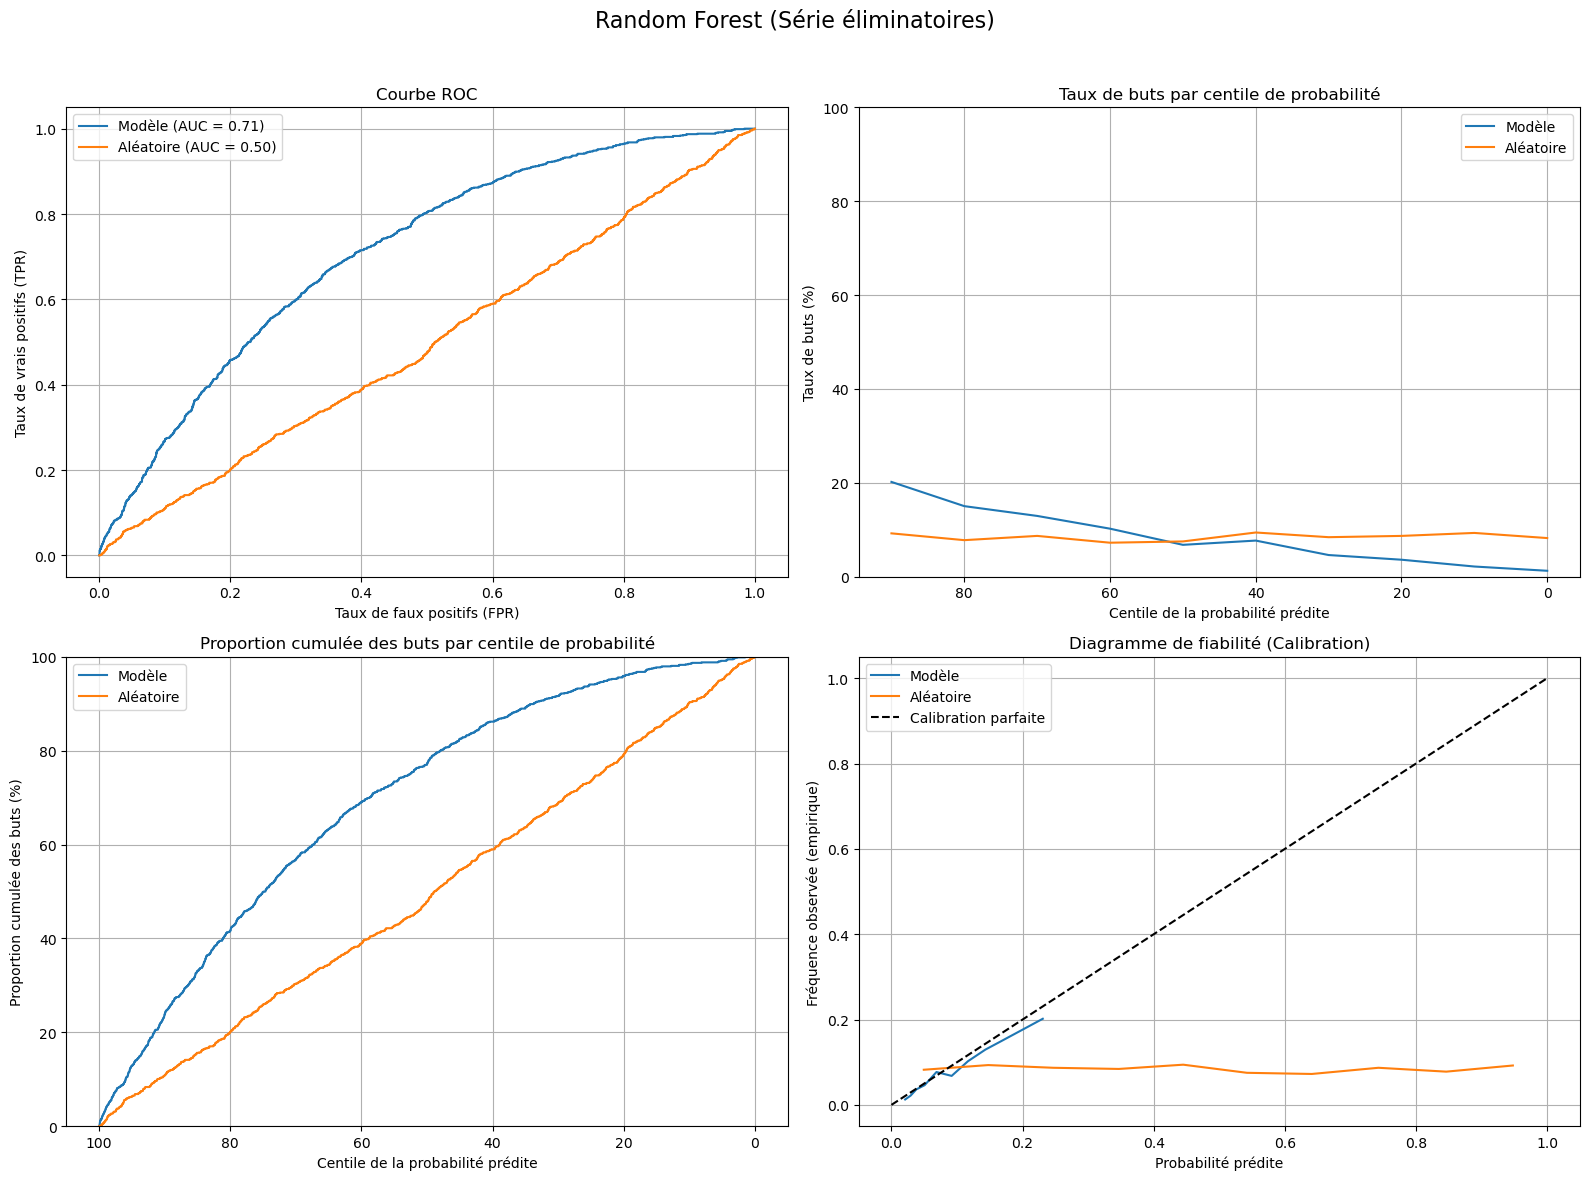

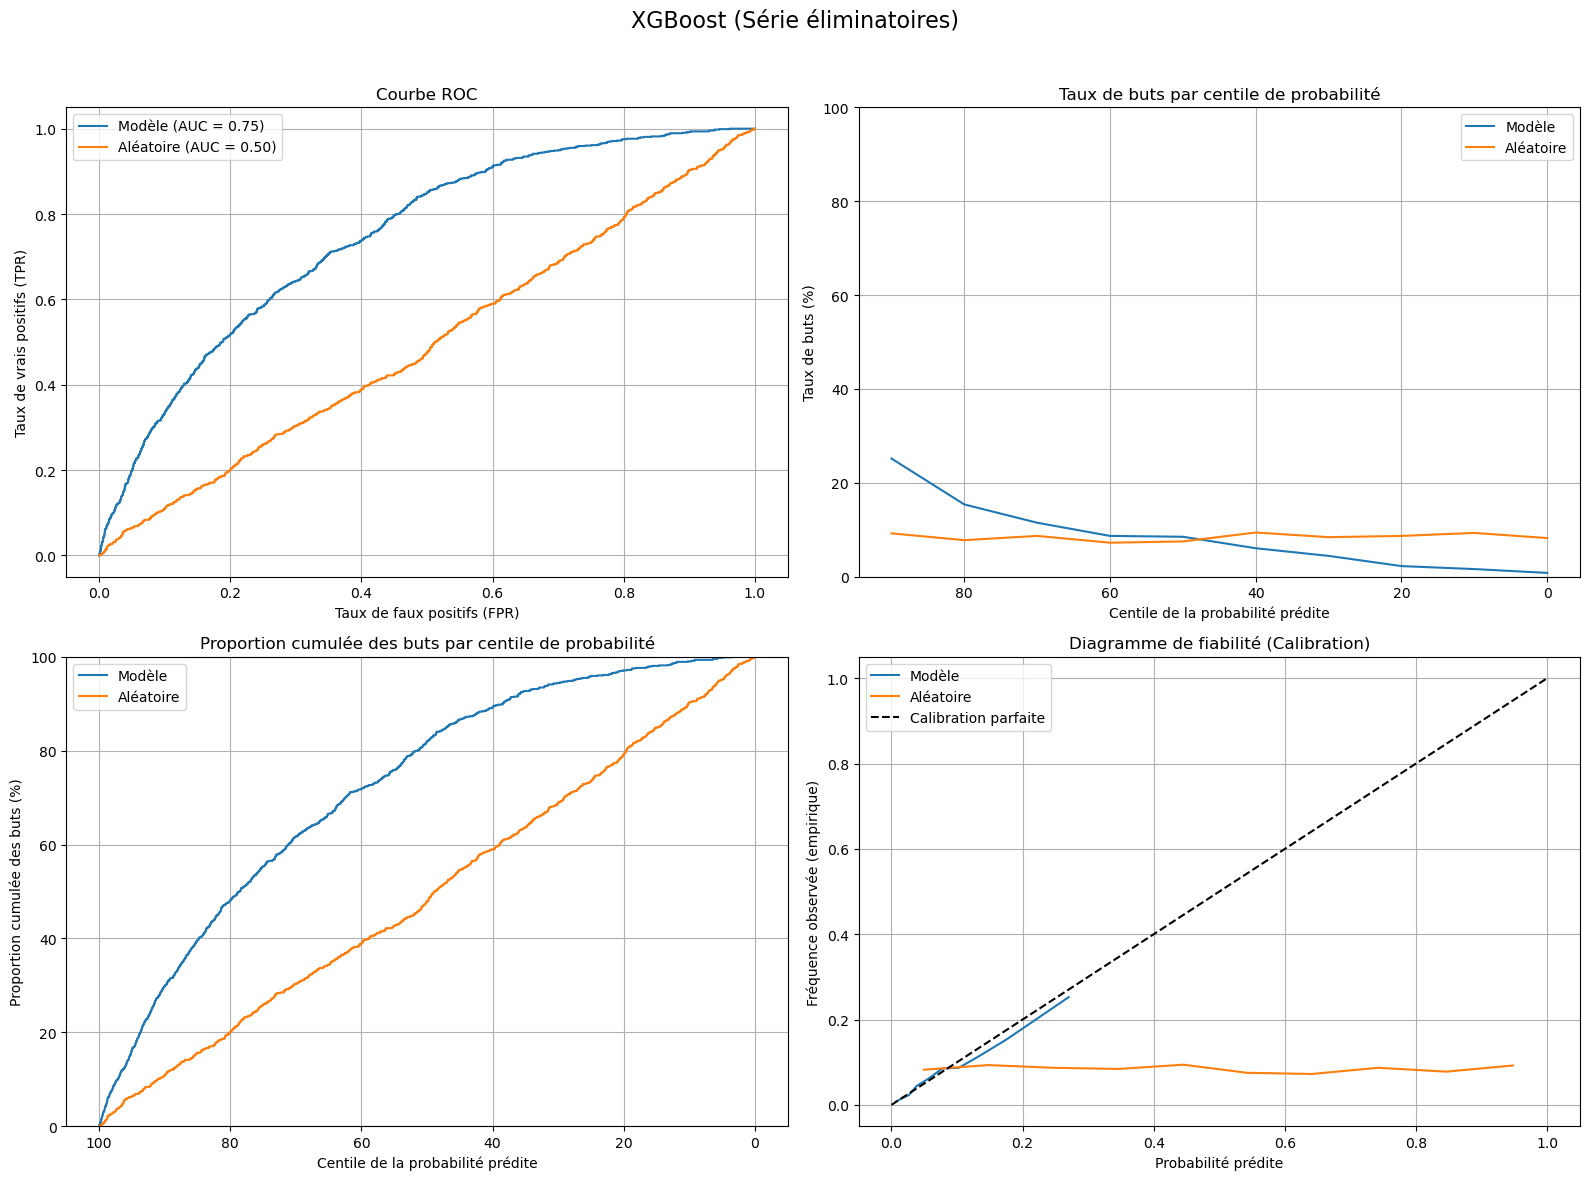

In [99]:
# Generate figures for each model
# Add a column of ones to X_all_features_std
generate_figures(lr_distance_model, X_shot_distance, y, "Logistic Regression (Distance)")
generate_figures(lr_angle_model, X_shot_angle, y, "Logistic Regression (Angle)")
generate_figures(lr_distance_angle_model, X_shot_distance_angle, y, "Logistic Regression (Distance + Angle)")
generate_figures(rf_model, X_all_features_std, y, "Random Forest")
generate_figures(xgboost_model, X_all_features, y, "XGBoost")